## Assignment 1: Balancing a Pole on a Cart



### Import Required Dependencies & Set Up Environment

In [1]:
# Import necessary libraries
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print("\n")
print(env.observation_space)
print("\n")
observation = env.reset()
print("Initial observations:", observation)


Discrete(2)


Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Initial observations: (array([-0.01594995, -0.03691231, -0.02319036, -0.03327468], dtype=float32), {})


### Task 1: Development of a RL Agent

#### Training of a Q-Learning RL Model
Acknowledgement for Code Reference: https://aleksandarhaber.com/q-learning-in-python-with-tests-in-cart-pole-openai-gym-environment-reinforcement-learning-tutorial/

In [141]:
class Q_Learning:

    # INPUTS: 
    # env - Cart Pole environment
    # alpha - step size 
    # gamma - discount rate
    # epsilon - parameter for epsilon-greedy approach
    # numberEpisodes - total number of simulation episodes
     
    # numberOfBins - this is a 4 dimensional list that defines the number of grid points 
    # for state discretization
    # that is, this list contains number of bins for every state entry, 
    # we have 4 entries, that is,
    # discretization for cart position, cart velocity, pole angle, and pole angular velocity
     
    # lowerBounds - lower bounds (limits) for discretization, list with 4 entries:
    # lower bounds on cart position, cart velocity, pole angle, and pole angular velocity
 
    # upperBounds - upper bounds (limits) for discretization, list with 4 entries:
    # upper bounds on cart position, cart velocity, pole angle, and pole angular velocity
     
    def __init__(self,env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds):
        import numpy as np
         
        self.env=env
        self.alpha=alpha
        self.gamma=gamma 
        self.epsilon=epsilon 
        self.actionNumber=env.action_space.n 
        self.numberEpisodes=numberEpisodes
        self.numberOfBins=numberOfBins
        self.lowerBounds=lowerBounds
        self.upperBounds=upperBounds
         
        # this list stores sum of rewards in every learning episode
        self.sumRewardsEpisode=[]
         
        # this matrix is the action value function matrix 
        self.Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],self.actionNumber))
         

     
    ###########################################################################
    # START: function "returnIndexState"
    # for the given 4-dimensional state, and discretization grid defined by 
    # numberOfBins, lowerBounds, and upperBounds, this function will return 
    # the index tuple (4-dimensional) that is used to index entries of the 
    # of the QvalueMatrix 
 
 
    # INPUTS:
    # state - state list/array, 4 entries: 
    # cart position, cart velocity, pole angle, and pole angular velocity
 
    # OUTPUT: 4-dimensional tuple defining the indices of the QvalueMatrix 
    # that correspond to "state" input
 
    ###############################################################################
    def returnIndexState(self,state):
        position =      state[0]
        velocity =      state[1]
        angle    =      state[2]
        angularVelocity=state[3]
         
        cartPositionBin=np.linspace(self.lowerBounds[0],self.upperBounds[0],self.numberOfBins[0])
        cartVelocityBin=np.linspace(self.lowerBounds[1],self.upperBounds[1],self.numberOfBins[1])
        poleAngleBin=np.linspace(self.lowerBounds[2],self.upperBounds[2],self.numberOfBins[2])
        poleAngleVelocityBin=np.linspace(self.lowerBounds[3],self.upperBounds[3],self.numberOfBins[3])
         
        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)
         
        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])   

    # this function selects an action on the basis of the current state 
    # INPUTS: 
    # state - state for which to compute the action
    # index - index of the current episode
    def selectAction(self,state,index):
         
        # first 500 episodes we select completely random actions to have enough exploration
        if index<100:
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0]) % self.actionNumber
        else:
            randomNumber=np.random.random()
            
            # after 7000 episodes, we slowly start to decrease the epsilon parameter
            if index>7000:
                self.epsilon=0.999*self.epsilon
            
            # if this condition is satisfied, we are exploring, that is, we select random actions
            if randomNumber < self.epsilon:
                # returns a random action selected from: 0,1,...,actionNumber-1
                return np.random.choice(self.actionNumber)            
            
            # otherwise, we are selecting greedy actions
            else:
                # we return the index where Qmatrix[state,:] has the max value
                # that is, since the index denotes an action, we select greedy actions
                # return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
                stateIndex = self.returnIndexState(state)
                maxActionIndex = np.argmax(self.Qmatrix[stateIndex])
                return maxActionIndex % self.actionNumber


      
    def simulateEpisodes(self):
        import numpy as np
        # here we loop through the episodes
        for indexEpisode in range(self.numberEpisodes):
             
            # list that stores rewards per episode - this is necessary for keeping track of convergence 
            rewardsEpisode=[]
             
            # reset the environment at the beginning of every episode
            (stateS,_)=self.env.reset()
            stateS=list(stateS)
           
            print("Simulating episode {}".format(indexEpisode))
             
             
            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state
                 
                stateSIndex=self.returnIndexState(stateS)
                 
                # select an action on the basis of the current state, denoted by stateS
                actionA = self.selectAction(stateS,indexEpisode)
                 
                 
                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (stateSprime, reward, terminalState,_,_) = self.env.step(actionA)          
                 
                rewardsEpisode.append(reward)
                 
                stateSprime=list(stateSprime)
                 
                stateSprimeIndex=self.returnIndexState(stateSprime)
                 
                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(self.Qmatrix[stateSprimeIndex])                                               
                                              
                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0 
                    error=reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                 
                # set the current state to the next state                    
                stateS=stateSprime
         
            print("Sum of rewards {}".format(np.sum(rewardsEpisode)))        
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))
  

    # OUTPUT: 
    # env1 - created Cart Pole environment
    # obtainedRewards - a list of obtained rewards during time steps of a single episode
     
    # simulate the final learned optimal policy
    def simulateLearnedStrategy(self):
        import gym 
        import time
        env1=gym.make('CartPole-v1')
        (currentState,_)=env1.reset()
        env1.render()
        timeSteps=1000
        # obtained rewards at every time step
        obtainedRewards=[]
         
        for timeIndex in range(timeSteps):
            print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated, info =env1.step(actionInStateS)
            obtainedRewards.append(reward)   
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env1

    #  OUTPUT:
    # sumRewardsEpisodes - every entry of this list is a sum of rewards obtained by simulating the corresponding episode
    # env2 - created Cart Pole environment
    def simulateRandomStrategy(self):
        import gym 
        import time
        import numpy as np
        env2=gym.make('CartPole-v1')
        (currentState,_)=env2.reset()
        env2.render()
        # number of simulation episodes
        episodeNumber=100
        # time steps in every episode
        timeSteps=1000
        # sum of rewards in each episode
        sumRewardsEpisodes=[]
         
         
        for episodeIndex in range(episodeNumber):
            rewardsSingleEpisode=[]
            initial_state=env2.reset()
            print(episodeIndex)
            for timeIndex in range(timeSteps):
                random_action=env2.action_space.sample()
                observation, reward, terminated, truncated, info =env2.step(random_action)
                rewardsSingleEpisode.append(reward)
                if (terminated):
                    break     
            sumRewardsEpisodes.append(np.sum(rewardsSingleEpisode))
        return sumRewardsEpisodes,env2

In [148]:
env=gym.make('CartPole-v1')
(state,_)=env.reset()

 
# here define the parameters for state discretization
upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-5
cartVelocityMax=5
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin
 
numberOfBinsPosition=30
numberOfBinsVelocity=30
numberOfBinsAngle=30
numberOfBinsAngleVelocity=30
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]
 
# define the parameters
alpha=0.5
gamma=0.99
epsilon=0.01
numberEpisodes=100

# create an object
Q1=Q_Learning(env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds)

In [149]:
observation = env.reset()
print("Observation: ", observation)
action = Q1.selectAction(observation, 0)
print("Chosen action: ", action)

Observation:  (array([-0.03981084,  0.02646502, -0.01604285, -0.00579732], dtype=float32), {})


IndexError: tuple index out of range

-----
### Task 2: Demonstrate Effectiveness of the RL Agent

Simulating episode 0
Sum of rewards 38.0
Simulating episode 1
Sum of rewards 10.0
Simulating episode 2
Sum of rewards 9.0
Simulating episode 3
Sum of rewards 86.0
Simulating episode 4
Sum of rewards 18.0
Simulating episode 5
Sum of rewards 44.0
Simulating episode 6
Sum of rewards 18.0
Simulating episode 7
Sum of rewards 17.0
Simulating episode 8
Sum of rewards 14.0
Simulating episode 9
Sum of rewards 11.0
Simulating episode 10
Sum of rewards 10.0
Simulating episode 11
Sum of rewards 19.0
Simulating episode 12
Sum of rewards 15.0
Simulating episode 13
Sum of rewards 14.0
Simulating episode 14
Sum of rewards 14.0
Simulating episode 15
Sum of rewards 15.0
Simulating episode 16
Sum of rewards 17.0
Simulating episode 17
Sum of rewards 36.0
Simulating episode 18
Sum of rewards 12.0
Simulating episode 19
Sum of rewards 10.0
Simulating episode 20
Sum of rewards 10.0
Simulating episode 21
Sum of rewards 16.0
Simulating episode 22
Sum of rewards 22.0
Simulating episode 23
Sum of rewards 12.0
Sim

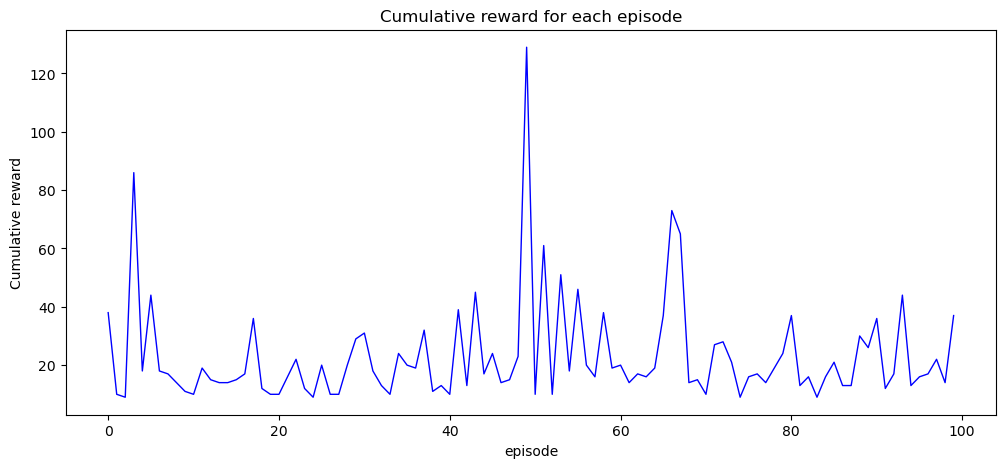

0
1
2
3
4
5
6
7
8
9
10


In [110]:

# run the Q-Learning algorithm
Q1.simulateEpisodes()
# simulate the learned strategy
(obtainedRewardsOptimal,env1)=Q1.simulateLearnedStrategy()
plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(Q1.sumRewardsEpisode,color='blue',linewidth=1)
plt.title("Cumulative reward for each episode")
plt.xlabel('episode')
plt.ylabel('Cumulative reward')
plt.show()
# plt.savefig('convergence.png') 
 
 
# close the environment
env1.close()
# get the sum of rewards
np.sum(obtainedRewardsOptimal)
 
# # now simulate a random strategy
# (obtainedRewardsRandom,env2)=Q1.simulateRandomStrategy()
# plt.hist(obtainedRewardsRandom)
# plt.xlabel('Sum of rewards')
# plt.ylabel('Percentage')
# # plt.savefig('histogram.png') 
# plt.show()
 
# run this several times and compare with a random learning strategy
(obtainedRewardsOptimal,env1)=Q1.simulateLearnedStrategy()



In [60]:
def Average(list):
    ld = sorted(list, reverse=True)
    highestValues = ld[:100]
    return np.average(highestValues)

print("Average cumulative reward: ", round(Average(Q1.sumRewardsEpisode), 2))
print("Is my agent good enough?", Average(Q1.sumRewardsEpisode) > 195)

Average cumulative reward:  21.5
Is my agent good enough? False
